### Тематическое моделирование

Мы уже использовали снижение размерности пространства при анализе текстов. Еще одним вариантом такого снижения является тематическое моделирование. Для него используются следующие рассуждения.

Пусть дан набор текстов, в каждом тексте имеются определенные слова. В таком случае можно посчитать матрицу термины-документы, в которой по строкам будут идти термины, по столбцам документы, а на пересечении будет стоять частота термина в данном документе. 
<img  width="40%" src="img/term-document-matrix-bow-annotated.png">


При помощи элементарных математических преобразований (метод SVD) данную матрицу можно представить в виде произведения трех матриц: матрицы слово на тематику, матрицы тематик и матрицы тематика на документ. Средняя из матриц будет квадратной и диагональной и будет содержать некоторые коэффициенты важности, которые можно отсортировать по убыванию. В этом случае размерность матрицы можно серьезно сократить, отбросив неактуальные темы. Для сокращения числа коэффициентов надо снизить размер матрицы $\Sigma$.

<img  width="40%" src="img/1024px-Singular-Value-Decomposition.svg.png"> 
<img  width="40%" src="img/800px-Singular_value_decomposition_visualisation.svg.png">

На основе SVD работает метод латентно-семантического анализа (LSA), который позволяет более четко найти связи между терминами и документами. Его более быстрая реализация, LDA, проводит нечеткий поиск. LSI является модификацией для задач информационного поиска.

Рассмотрим теперь пример применения SVD для задач классификации.

In [3]:
import pandas as pd
import numpy as np

import pymorphy2
import re
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

# Разложение матрицы на три с сокращением размерности.
from sklearn.decomposition import TruncatedSVD

Возьмем по тысяче научных текстов из пяти разных областей науки. (Они занимают 140 Мб и не влезают на Гит, так что доступны по запросу.)

In [7]:
sci_texts = pd.read_csv("data/kaggle-science-texts_train.tsv", header=0, sep = ';')

In [8]:
sci_texts.head()

,ID,Target,Text
0,1,0,...
1,2,0,...
2,3,0,...
3,4,0,...
4,5,0,...


In [9]:
%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(sci_texts['Text'])
# Проводим SVD-разложение по 20 компонентам.
svd = TruncatedSVD(n_components=20)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")
# Просто чтобы посмотреть, что там в самом деле вектора.
print(X2.shape, X2)

Explained variance of the SVD step: 8%
(5000, 20) [[ 0.18716104  0.05641833 -0.09603021 ... -0.02307696  0.01640995
  -0.02717252]
 [ 0.15355927 -0.00178643 -0.06001403 ...  0.02716141  0.01835929
   0.00857125]
 [ 0.12449795  0.01570731 -0.0664274  ... -0.06896912 -0.00185083
  -0.01839687]
 ...
 [ 0.27208788 -0.08811303 -0.06230478 ... -0.07376757 -0.01386871
  -0.09448614]
 [ 0.16188171 -0.07406499 -0.04233102 ... -0.05255982 -0.01317704
  -0.05548741]
 [ 0.33845172 -0.15522892 -0.07596138 ... -0.00669346  0.04598029
  -0.08536983]]
CPU times: user 18.7 s, sys: 11.7 s, total: 30.4 s
Wall time: 16.1 s


In [10]:
X

<5000x509412 sparse matrix of type '<class 'numpy.float64'>'
	with 5699630 stored elements in Compressed Sparse Row format>

Исходно, код ниже выполнялся 37 минут. Но если поставить<br>
`pip install pymorphy2[fast]`<br>
то библиотека начинает работать горазо быстрее.

Если морфология работает медленно, но в тексте вссегда есть повторяющиеся слова (кто знает что такое закон Ципфа?), то может быть результаты медленной морфологии надо кешировать в быстром словаре (dict)?

In [4]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [5]:
%%time
# Приведем слова в текстах к начальным формам.
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 32.9 s, sys: 79.6 ms, total: 33 s
Wall time: 33 s


In [6]:
%%time
X_l = TfidfVectorizer().fit_transform(sci_texts['NText'])
svd = TruncatedSVD(n_components=10)
X2_l = svd.fit_transform(X)

CPU times: user 9.58 s, sys: 9.68 s, total: 19.3 s
Wall time: 8.01 s


In [7]:
# Подготовим целевые переменные. Мы же знаем, что там ровно по 1000 текстов для каждой области.
classes = np.ones(5000)
for i in range(2, 6):
    classes[(i-1)*1000: i*1000] = i

In [9]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

А теперь сравним точность работы классификатора, запущенного на разных данных: с и без лемматизации; векторизация при помощи TF*IDF или SVD.

In [9]:
%%time
# TF*Idf без лемматизации.
classify_texts(X, classes)

accuracy = 0.979%
[[204   0   3   0   2]
 [  2 185   2   1   0]
 [  4   0 199   2   1]
 [  0   0   1 190   2]
 [  0   0   1   0 201]]
CPU times: user 10.8 s, sys: 27.4 ms, total: 10.8 s
Wall time: 10.8 s


In [10]:
%%time
# TF*Idf с лемматизацией.
classify_texts(X_l, classes)

accuracy = 0.97%
[[201   0   3   2   3]
 [  4 180   6   0   0]
 [  3   0 200   2   1]
 [  1   0   0 190   2]
 [  0   0   0   3 199]]
CPU times: user 5.76 s, sys: 12.8 ms, total: 5.77 s
Wall time: 5.77 s


In [11]:
%%time
# SVD без лемматизации.
classify_texts(X2, classes)

accuracy = 0.972%
[[204   0   3   1   1]
 [  3 181   6   0   0]
 [  1   1 202   2   0]
 [  1   2   1 187   2]
 [  0   0   0   4 198]]
CPU times: user 971 ms, sys: 431 µs, total: 971 ms
Wall time: 970 ms


In [12]:
%%time
# SVD с лемматизацией.
classify_texts(X2_l, classes)

accuracy = 0.966%
[[203   1   3   1   1]
 [  2 178   9   0   1]
 [  3   1 200   2   0]
 [  1   2   1 187   2]
 [  0   0   0   4 198]]
CPU times: user 704 ms, sys: 793 µs, total: 704 ms
Wall time: 703 ms


Получается, что с 10 компонентами, полученными при помощи SVD работает в 10 раз быстрее и немного точнее.

Вообще, для тематического моделирования текстов существует большая библиотека [BigARTM](http://bigartm.org/), но она не ставится так просто и не входит в стандартные библиотеки.

# Методы семантического анализа текстов

## Сходство между словами

You shall know a word by the company it keeps. 

*Firth*

 Варкалось. Хливкие шорьки<br>
   Пырялись по наве,<br>
   И хрюкотали зелюки,<br>
   Как мюмзики в мове.<br>

*Кэррол*

Не очень ясно что именно могут делать *зелюки*. Но если мы узнаем кто еще может *хрюкотать*, то мы можем посчитать, что нашли слово со сходным значением или, как минимум, относящееся к одной смысловой группе.

Аналогично мы не понимаем кто (что) такие *шорьки*. Если они бывают ответственными - это одно, если электронными - другое.

### Предобработка текста

Теперь возьмем новостные тексты с сайта Lenta.ru за лето 2018 года. Разделим каждый текст на предложения, а предложения на слова.

In [17]:
import pandas as pd
import re
import nltk
import nltk.data
from tqdm.notebook import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/edward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# Файл в своем хитром формате, его просто надо порезать по разделителям.
with open("data/lenta2018.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("=====\n")[1:]
    text_news = [(n.split('\n')[0], '\n'.join(n.split('\n')[2:])) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'News'])

In [12]:
# Всё ли прочиталось?
news.head()

,Header,News
0,Раскрыто происхождение новейшей украинской кры...,Испытанная Украиной первая собственная крылата...
1,Русских гопников назвали настоящими древними с...,Пользователи Reddit выразили симпатию российск...
2,Поезд с американскими политиками врезался в му...,В американском штате Вирджиния пассажирский по...
3,Открыт первый европейский бордель с секс-кукла...,"Во Франции открылся первый бордель, который сд..."
4,Социологи подсчитали планирующих проголосовать...,На выборы президента собирается прийти 71 проц...


Давайте поделим тексты на предложения, а предложения на слова

In [13]:
def text_to_sentences(text):
    """ Функция делит текст на предложения, а предложения на слова.
    """
    
    # Поделим текст на предложения при помощи NLTK.
    raw_sentences = nltk.sent_tokenize(text, language="russian")
    # Поделим предложения на слова при помощи регулярных выражений, заодно выкинем знаки препинания и цифры.
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.findall('[a-zA-Zа-яА-яёЁ]+', raw_sentence.lower()))
    return sentences

In [14]:
text_to_sentences(news['News'][11])

[['ракета',
  'носитель',
  'союз',
  'а',
  'с',
  'спутниками',
  'стартовала',
  'с',
  'космодрома',
  'восточный'],
 ['об',
  'этом',
  'сообщает',
  'космический',
  'центр',
  'южный',
  'который',
  'ведет',
  'прямую',
  'трансляцию',
  'запуска',
  'корабль',
  'должен',
  'доставить',
  'на',
  'орбиты',
  'спутников',
  'два',
  'из',
  'которых',
  'российские',
  'спутники',
  'дистанционного',
  'зондирования',
  'земли',
  'канопус',
  'в',
  'и',
  'это',
  'уже',
  'третий',
  'пуск',
  'с',
  'восточного'],
 ['предыдущий',
  'состоялся',
  'ноября',
  'года',
  'и',
  'завершился',
  'неудачей',
  'из',
  'за',
  'неполадок',
  'с',
  'разгонным',
  'блоком',
  'была',
  'утеряна',
  'головная',
  'часть',
  'ракеты',
  'союз',
  'б',
  'с',
  'спутниками',
  'на',
  'борту'],
 ['в',
  'госкорпорации',
  'роскосмос',
  'объяснили',
  'инцидент',
  'ошибкой',
  'в',
  'программном',
  'обеспечении',
  'разгонного',
  'блока',
  'и',
  'ракеты',
  'носителя',
  'заложе

In [15]:
news['News'][11]

'Ракета-носитель «Союз-2.1а» с 11 спутниками стартовала с космодрома Восточный. Об этом сообщает Космический центр «Южный», который ведет прямую трансляцию запуска.Корабль должен доставить на орбиты 11 спутников, два из которых — российские спутники дистанционного зондирования Земли «Канопус-В» №3 и №4.Это уже третий пуск с Восточного. Предыдущий состоялся 28 ноября 2017 года и завершился неудачей — из-за неполадок с разгонным блоком была утеряна головная часть ракеты «Союз-2.1б» (с 19 спутниками на борту). В госкорпорации «Роскосмос» объяснили инцидент ошибкой в программном обеспечении разгонного блока и ракеты-носителя, заложенной еще 20 лет назад. Позже вице-премьер России Дмитрий Рогозин заявил, что при подготовке запуска сотрудники перепутали космодромы: «Союз-2.1б» запускали с Восточного, при этом параметры траектории рассчитали с учетом старта с Байконура.В ближайшие годы «Роскосмос» ставит задачу повысить долю успешных запусков ракет-носителей до 99 процентов.\n'

In [16]:
all_sentences = sum([text_to_sentences(x) for x in news['News']], [])

In [17]:
all_sentences[0]

['испытанная',
 'украиной',
 'первая',
 'собственная',
 'крылатая',
 'ракета',
 'создана',
 'кб',
 'луч',
 'в',
 'рамках',
 'окр',
 'нептун',
 'на',
 'основе',
 'российской',
 'противокорабельной',
 'ракеты',
 'м',
 'комплекса',
 'х',
 'у']

## Модель Word2Vec

Модель описана в статье [Т.Миколова и др.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Идея метода основывается на оптимизации функционала, основанного на логарифмах вероятностей совместной встречаемости слов. Помимо этого, вводятся отрицательные примеры, вероятности которых не суммируются, а вычитаются. При этом отрицательных примеров берется больше, чем положительных.

Если говорить проще, то при обучении модель считает статистику, какое слово с каким сколько раз стояло рядом. За счет этого мы можем построить вектор частоты встречаемости слова с другими словами в одном окне текста заданной длины. Если два слова встречаются с одними и теми же словами с примерно одинаковой частотой (_котик кушает, бегает, спит, кусается_ и похожий на него _щенок кушает, бегает, спит, кусается, охраняет_), то это два похожих слова. Если два слова встречаются с разными словами (_котик кушает, бегает, спит, кусается_, но _электрон занимает орбиту, взаимодействует, перемещается_), значит это разные слова. У нас есть вектора слов большой размерности, нам надо впихнуть эти вектора в пространство меньшей размерности, положив похожие слова рядом, а непохожие - в разные места. Мы уже где-то встречали эту задачу! Но Миколов и др. использовали для ее решения простой персептрон.

Можно провести аналогию с SVD. У нас строится некоторое пространство, размерность которого определяется числом латентных переменных в системе - скрытых параметров, каждый из которых отвечает за какой-то "смысл": размер, цвет, политика, время, абстрактность, падеж слова и прочее. Количество признаков в этом пространстве определяется числом подобных скрытых переменных.

Не вникая в особенности устройства модели, научимся ею пользоваться. Для этого будем использовать библиотеку Gensim.

In [19]:
# Импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

### Использование предобученных моделей

У нас есть два пути:
- взять большое количество текстов и обучить на них собственную модель;
- найти модель, которую уже обучили добрые люди и выложили в сеть.

Сперва пойдем по второму пути - загрузим модель, обученную разработчиками проекта <a href="http://rusvectores.org/ru/models/">RusVectores</a> для русского языка на новостях. Я ее уже скачал и она лежит в каталоге `data`.

In [20]:
# Загружаем модель в память.
model_w2v = KeyedVectors.load_word2vec_format('data/araneum_upos_skipgram_300_2_2018.vec.gz')

Теперь можно получить представление слов в новом пространстве. Имейте в виду, что в данной модели слова сохранены с частями речи, чтобы различать разные значения!

In [14]:
# Передаем модели слово с частью речи, получаем вектор.
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [15]:
# Просим модель вернуть нам несколько слов, наиболее похожих на данное там в семантическом пространстве.
model_w2v.most_similar('интернет_NOUN')

[('интеренет_NOUN', 0.924296498298645),
 ('интерент_NOUN', 0.9155471920967102),
 ('интренет_NOUN', 0.9038118720054626),
 ('интрнет_NOUN', 0.8466425538063049),
 ('итернет_NOUN', 0.834010660648346),
 ('интенета_NOUN', 0.8012408018112183),
 ('инетрнет_NOUN', 0.7921422719955444),
 ('интерет_NOUN', 0.786211371421814),
 ('инетернет_NOUN', 0.7794284224510193),
 ('интернт_NOUN', 0.7663599252700806)]

In [16]:
model_w2v.most_similar('ученый_NOUN')

[('исследователь_NOUN', 0.8123084902763367),
 ('биолог_NOUN', 0.7502084374427795),
 ('астрофизик_NOUN', 0.7438788414001465),
 ('ученый_ADJ', 0.7298716306686401),
 ('нейрофизиолог_NOUN', 0.7224255204200745),
 ('нейробиолог_NOUN', 0.7219529151916504),
 ('климатолог_NOUN', 0.7159756422042847),
 ('зоолог_NOUN', 0.7055575251579285),
 ('астроном_NOUN', 0.7006036639213562),
 ('палеонтолог_NOUN', 0.6994451880455017)]

В полученном пространстве работают векторные операции. Если обучиться на достаточно большом количестве текстов, можно получить следующие эффекты.

![](img/w2v_vect.png)

![](img/w2v_vect2.png)



На хорошо обученной модели можно даже превратить индекс в город и наоборот при помощи векторных операций.

Попробуем эти векторные операции своими руками.

In [22]:
# Список всех слов
list(model_w2v.key_to_index.keys())[:20]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN']

In [27]:
lens = np.array([np.linalg.norm(model_w2v[word]) for word in model_w2v.key_to_index.keys()])
lens[lens > 1.01]   
lens[0]

0.9999996

$$cos(a,b) = \frac{\sum{a_i*b_i}}{\sqrt{\sum{a_i^2}*\sum{b_i^2}}} = \sum{a_i*b_i} $$

In [26]:
model_w2v.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
# model_w2v.most_similar(positive=[u'птица_NOUN', u'плавник_NOUN'], negative=[u'крыло_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN'], negative=[u'пламя_NOUN' ])
#model_w2v.most_similar(positive=[u'топливо_NOUN', u'молоко_NOUN'], negative=[u'нефть_NOUN' ])
# model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
# model_w2v.most_similar(positive=[u'президент_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
# model_w2v.most_similar(negative=[u'король_NOUN', u'мужчина_NOUN'], positive=[u'женщина_NOUN'])
# model_w2v.most_similar(positive=[u'король_NOUN', u'мужчина_NOUN'], negative=[u'женщина_NOUN'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'король_NOUN' ])
# model_w2v.most_similar(positive=[u'берлин_PROPN', u'москва_PROPN' ], negative=[u'германия_PROPN'])
# model_w2v.most_similar(positive=[u'германия_PROPN', u'москва_PROPN' ], negative=[u'берлин_PROPN'])
# model_w2v.most_similar(positive=[u'сербия_PROPN', u'москва_PROPN' ], negative=[u'белград_PROPN'])


[('королева_NOUN', 0.7022064328193665),
 ('герцог_NOUN', 0.6763379573822021),
 ('монарх_NOUN', 0.6703874468803406),
 ('генрих_PROPN', 0.656510055065155),
 ('людовик_PROPN', 0.656411349773407),
 ('франция::людовик_PROPN', 0.6421706080436707),
 ('принц_NOUN', 0.6407060027122498),
 ('королевство_NOUN', 0.6257355809211731),
 ('наследный_ADJ', 0.6177536845207214),
 ('герцогиня_NOUN', 0.617081344127655)]

Можно найти лишнее слово в последовательности.

In [27]:
model_w2v.doesnt_match(['лук_NOUN', 'перец_NOUN', 'ученик_NOUN', 'плодовый_ADJF'])

'ученик_NOUN'

Итак, вместо самих слов мы можем использовать их векторные представления в некотором семантическом пространстве.

<img src="img/cartoon-espresso-word2vec.jpg">

Беда Word2Vec состоит в том, что он генерирует только один вектор на каждое слово. То есть он не различает различных смыслов одного слова.

<img src="img/cartoon-citizen-data-scientist.jpg">

### Как устроено векторное пространство?

Давайте посмотрим на реальное расположение слов в этом пространстве. Для этого нам потребуется UMAP, а то как еще мы преобразуем 300-мерное пространство в плоскость? Просто преобразуем полученные от модели 300-мерные вектора в плоскость и полюбуемся результатом.

In [28]:
from umap import UMAP
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

Чтобы любоваться предметно, возьмем названия разных растений, условно разделенных на травы и деревья. Это поможет нам оценить, насколько близко или далеко оказываются сходные слова.

In [29]:
# Прочитаем слова из файлов.
trees = pd.read_csv("data/trees.txt", sep='\t', names=['trees'])
herbs = pd.read_csv("data/herbs.txt", sep='\t', names=['herbs'])
# Положим их в таблицы.
trees = trees['trees'].str.lower().unique()
herbs = herbs['herbs'].str.lower().unique()

In [30]:
def draw_plants(model_w2v, trees, herbs):
    """ Функция принимает на вход модель Word2Vec и списки деревьев и трав.
        Для каждого слова получается его вектор, вектора преобразуются к 2D и отрисовываются.
    """
    
    # Получаем вектора слов, заодно отсеивая слова, отсутствующие в модели.
    all_vect, all_names, all_types = [], [], []

    for plants, plant_type in zip([trees, herbs], [1, 0]):
        for m in plants:
            # Работать с Word2Vec можно немного по-разному...
            if type(model_w2v) is KeyedVectors and \
               m.strip().lower()+'_NOUN' in model_w2v.key_to_index.keys():
                # Но нам в любом случае надо проверить если слово в модели и добавить его вектор.
                all_vect.append(model_w2v[m.strip().lower()+'_NOUN'])
                all_names.append(m)
                all_types.append(plant_type)
#             if ((type(model_w2v) is Word2Vec) or \
#                 (type(model_w2v) is gensim.models.word2vec.Word2Vec)) and \
            elif type(model_w2v) is Word2Vec and \
               m.strip().lower()+'_NOUN' in model_w2v.wv.key_to_index.keys():
                all_vect.append(model_w2v.wv[m.strip().lower()+'_NOUN'])
                all_names.append(m)
                all_types.append(plant_type)
#             else:
#                 print(type(model_w2v), m)

    # Преобразовываем к 2D.
    umaped_vct=UMAP().fit_transform(all_vect)
    
    # Рисуем все слова, деревья и травы разным цветом.
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=all_types, s=3)

    # Смотрим куда попали родовые понятия, рисуем их красным.
    for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
        ind = all_names.index(word)
        ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

    # Добавляем названия для нарисованных точек.
    for n, v in zip(all_names, umaped_vct):
        ax.annotate(n, (v[0], v[1]))

    plt.show()
    return all_vect, all_names

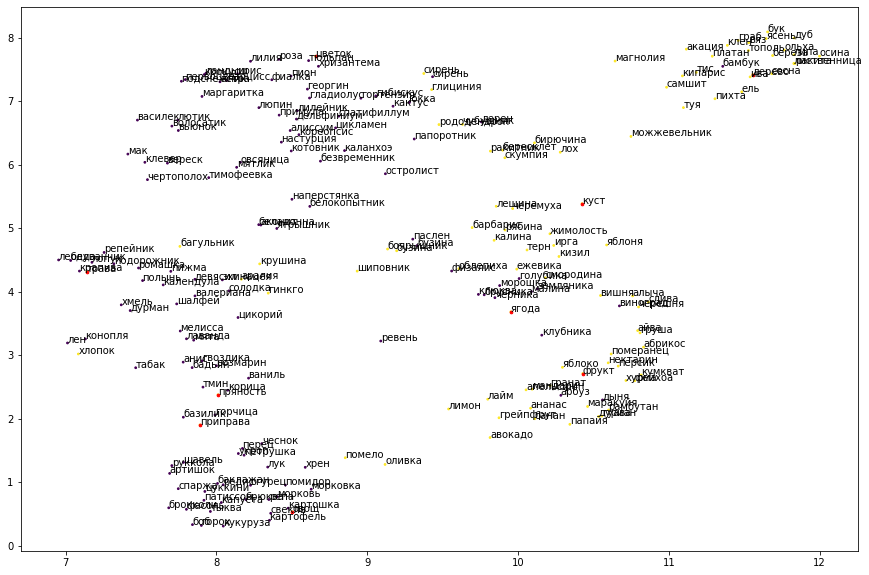

In [31]:
all_vect, all_names = draw_plants(model_w2v, trees, herbs)

А теперь давайте добавим ещё одно измерение и посмотрим, как точки будут меняться вдоль него.

In [32]:
from ipywidgets import interact, FloatSlider

In [33]:
umaped_vct = UMAP(n_components=3).fit_transform(all_vect)

In [34]:
def drawHerbs(val):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    temp_data = np.array([u for u in umaped_vct if u[2]>=val-0.5 and u[2]<=val+0.5])
    temp_names = [all_names[i] for i, u in enumerate(umaped_vct) if u[2]>=val-0.5 and u[2]<=val+0.5]
    
    ax.scatter(temp_data[:, 0], temp_data[:, 1], c=temp_data[:, 2], s=30)

    for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
        ind = all_names.index(word)
        ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)
        ax.annotate(word, (umaped_vct[ind, 0], umaped_vct[ind, 1]))

    for n, v in zip(temp_names, temp_data):
        ax.annotate(n, (v[0], v[1]))

    plt.show()

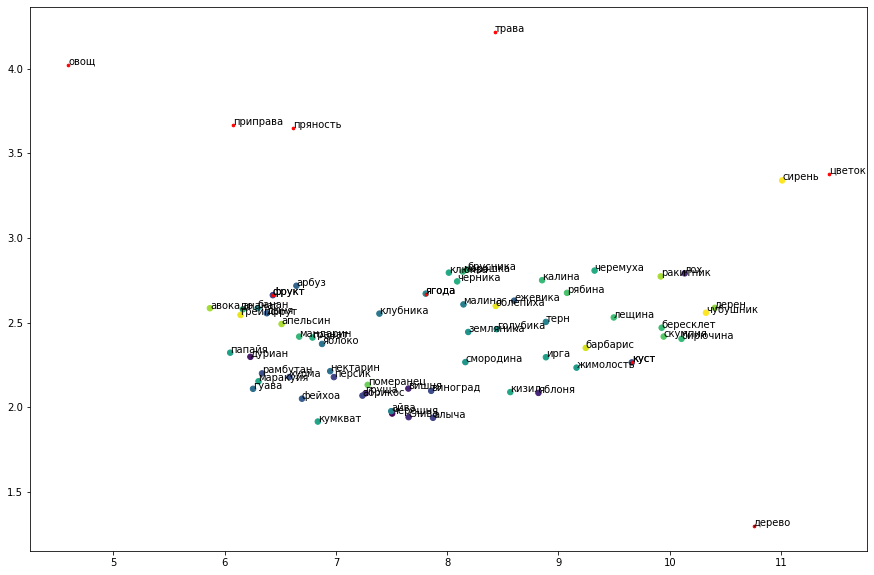

interactive(children=(FloatSlider(value=6.042667388916016, description='Filter by Z', max=8.182775497436523, m…

In [35]:
sld1 = FloatSlider(value=(min(umaped_vct[:, 2])+max(umaped_vct[:, 2]))/2, 
sld1 = FloatSlider(value=(min(umaped_vct[:, 2])+max(umaped_vct[:, 2]))/2, 
                   min=min(umaped_vct[:, 2]), max=max(umaped_vct[:, 2]), 
                   step=0.1, description='Filter by Z')

interact(drawHerbs, val=sld1);

### Обучение собственной модели в Word2Vec


Теперь посмотрим как можно обучить свою собственную модель. Это бывает необходимо, если у вас некоторая особая предметная область, понятия которой не встречаются, например, в новостных текстах или в обсуждениях фильмов.

In [32]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_news = Word2Vec(all_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 2.3 s, sys: 13.2 ms, total: 2.32 s
Wall time: 910 ms


Возьмем по тысяче научных текстов из пяти разных областей науки.

In [33]:
sci_sentences = []
for text in tqdm(sci_texts.Text):
    sci_sentences.append(normalizePymorphy(text))

  0%|          | 0/5000 [00:00<?, ?it/s]

Никто не сказал, что 300 параметров на вектор - это что-то обязательное.

In [34]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 50  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 4     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_sci = Word2Vec(sci_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 1min 22s, sys: 149 ms, total: 1min 22s
Wall time: 22.2 s


In [35]:
# Посмотрим на самые похожие слова.
model_our_sci.wv.most_similar('продукт_NOUN'), model_our_sci.wv.most_similar('система_NOUN')

([('медиапродукт_NOUN', 0.620564877986908),
  ('продукция_NOUN', 0.6013638973236084),
  ('медиаконтент_NOUN', 0.5905212163925171),
  ('мороженое_NOUN', 0.5689236521720886),
  ('концентрат_NOUN', 0.5663899183273315),
  ('антиокислитель_NOUN', 0.5661187767982483),
  ('ингредиент_NOUN', 0.5657021403312683),
  ('творог_NOUN', 0.5620144009590149),
  ('контент_NOUN', 0.5436139106750488),
  ('наполнитель_NOUN', 0.5348231196403503)],
 [('подсистема_NOUN', 0.760349690914154),
  ('целостность_NOUN', 0.6414169073104858),
  ('директивный_ADJ', 0.6355037093162537),
  ('взаимосвязанный_ADJ', 0.6337609887123108),
  ('маслообразователь_NOUN', 0.6232755780220032),
  ('управляемый_ADJ', 0.6178759336471558),
  ('взаимозависимый_ADJ', 0.6045579314231873),
  ('непрерывный_ADJ', 0.5960009694099426),
  ('интегрировать_ADJ', 0.5894928574562073),
  ('единый_ADJ', 0.5796623229980469)])

In [36]:
model_our_sci.wv.most_similar('говорить_VERB')

[('видеть_VERB', 0.8431699275970459),
 ('казаться_VERB', 0.8128820061683655),
 ('пытаться_VERB', 0.7953654527664185),
 ('знать_VERB', 0.7678140997886658),
 ('понимать_VERB', 0.7505525946617126),
 ('хотеть_VERB', 0.7492073774337769),
 ('интересовать_VERB', 0.7331315279006958),
 ('объяснять_VERB', 0.7315680384635925),
 ('отказываться_VERB', 0.7260881662368774),
 ('далёкий_ADJ', 0.7245804071426392)]

In [37]:
model_our_sci.wv.most_similar('ученик_NOUN')

[('учитель_NOUN', 0.8160618543624878),
 ('ребята_NOUN', 0.7651228904724121),
 ('мастерская_NOUN', 0.7442283630371094),
 ('воспитатель_NOUN', 0.7428896427154541),
 ('педагог_NOUN', 0.7414441704750061),
 ('учить_VERB', 0.7378830909729004),
 ('родитель_NOUN', 0.7203831672668457),
 ('учиться_ADJ', 0.71396803855896),
 ('сверстник_NOUN', 0.7092160582542419),
 ('желание_NOUN', 0.7016321420669556)]

In [38]:
model_our_sci.wv.most_similar('орех_NOUN')

[('грецкий_ADJ', 0.9164054989814758),
 ('перец_NOUN', 0.9063419103622437),
 ('лук_NOUN', 0.8974375128746033),
 ('молотый_ADJ', 0.8860057592391968),
 ('морковь_NOUN', 0.8830319046974182),
 ('крапива_NOUN', 0.8808957934379578),
 ('кориандр_NOUN', 0.8807321190834045),
 ('репчатый_ADJ', 0.877826988697052),
 ('сельдерей_NOUN', 0.8765299320220947),
 ('петрушка_NOUN', 0.871113657951355)]

In [39]:
# Размер проанализированного корпуса
model_our_sci.corpus_total_words

7357193

In [44]:
# Размерность векторов.
model_our_sci.vector_size

50

Посмотрим как будут отображаться растения на новой модели, обученной на "ученых" словах.

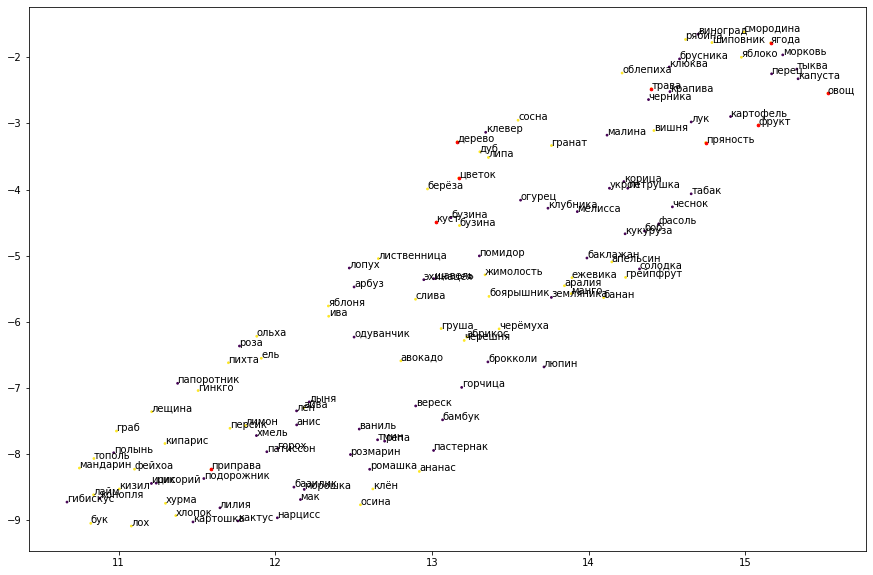

In [40]:
_ = draw_plants(model_our_sci, trees, herbs)

На модели, обученной на новостях пробовать не будем. Там таких слов нет вовсе.

----

## Векторизация текстов

Работать с векторами слов бывает очень полезно. Так, например, если нам нужно подать на вход нейросети вектор предложения, то мы можем предположить, что предложения не содержат больше 200 слов. Тогда на потребуется вектор длины `200 * 300 = 60 000` чтобы отдать любое предложение. На место имеющихся слов запишем их вектор, на место тех, что выходят за длину предложения - нули. 

Но иногда бывает необходимо работать с текстом как вектором. В такой ситуации удобно взять векторы всех слов в тексте и посчитать их средний вектор, считая что именно он будет представлять некоторый усредненный "смысл" текста.

Так как нам теперь придется работать не просто с начальными формами слов, а с их векторами, а вектора в имеющейся модели можно получить только по начальной форме и части речи, то нам необходимо написать фунцию для разметки текстов так, чтобы выход содержал в себе и часть речи. Заодно будем брать только слова со значимыми частями речи: прилагательные, существительные и глаголы.

In [41]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN',
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}
tmp_dict = {}
nones = {}

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

Теперь посмотрим какова размерность векторов, хранимых в модели, и сколько в ней слов.<br>
Размерность векторов 300 - с запасом. Почти 200 000 слов - тоже очень хорошо.

In [47]:
print(model_w2v.vector_size)
print(len(model_w2v.index_to_key))

300
196620


Можно посмотреть на слова, которые есть в модели. Если какого слова в ней нет, модель не вернет вектор для этого слова.

In [48]:
model_w2v.index_to_key[:50]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN',
 'вопрос_NOUN',
 'хороший_ADJ',
 'должный_ADJ',
 'вид_NOUN',
 'город_NOUN',
 'сайт_NOUN',
 'случай_NOUN',
 'дело_NOUN',
 'дом_NOUN',
 'сделать_VERB',
 'давать_VERB',
 'говорить_VERB',
 'россия_PROPN',
 'возможность_NOUN',
 'высокий_ADJ',
 'страна_NOUN',
 'область_NOUN',
 'мир_NOUN',
 'работать_VERB',
 'данный_ADJ',
 'начинать_VERB',
 'часть_NOUN',
 'качество_NOUN',
 'знать_VERB',
 'сказать_VERB',
 'позволять_VERB',
 'хорошо_ADV',
 'хотеть_VERB',
 'нужно_ADV',
 'принимать_VERB']

У нас есть смысл отдельных слов. Построим на его основе смысл текста как среднее арифметическое всех векторов для слов, составляющих данный текст.

In [42]:
index2word_set = set(model_w2v.index_to_key)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


Рассчитаем вектора всех текстов - они нам еще пригодятся.

In [43]:
w2v_vectors = [text_to_vec(text) for text in news.News]

Найдем текст, самый похожий на некоторый текст.

In [46]:
vpos = 72
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-w2v_vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
print(news.News[vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

В одной из больниц Флориды скончался американец Ли Гоггин, который попал под обвал дюны на одном из городских пляжей. Об этом на своей странице в Facebook рассказала сестра погибшего Рейчел.Мужчина находился в состоянии медикаментозной комы в течение двух дней и умер от остановки сердца. Ему было 33 года. У него остались жена и трое детей.Материалы по теме00:09 — 17 январяБомбический отдыхЧто делать туристу во время ядерной войныРанее сообщалось, что инцидент произошел в воскресенье, 28 января, на пляже Кресент во Флориде. Ли Гоггин из Техаса отдыхал с семьей и решил ради шутки закопать себя в песок. Внезапно туннель, который он вырыл, обрушился под ним, и мужчину засыпало песком от расположенных вокруг дюн. В отчете полиции говорится, что члены семьи пытались выкопать мужчину самостоятельно, однако у них ничего не вышло, и они вызвали службу спасения.Спасатели извлекли Гоггина в состоянии остановки сердца из ямы глубиной около метра, где он провел около 30 минут. После восстановления 

Теперь посмотрим как распределятся тексты в новом пространстве.

In [47]:
umap_news = UMAP()
umaped_vct = umap_news.fit_transform(w2v_vectors)

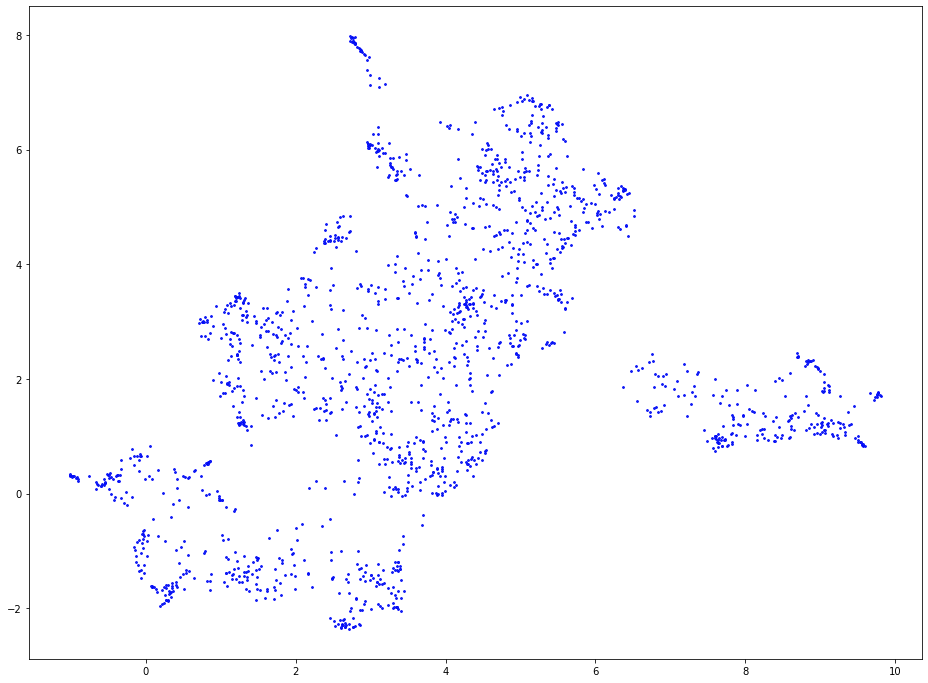

In [48]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice

In [51]:
def cluster_texts_and_draw(vectors, umaped_vct, eps):
    """ Функция кластеризует вектора vectors при помощи DBSCAN, используя eps в качестве параметра,
        и отображает их на плоскость, используя umaped_vct.
    """
    # Кластеризуем данные при помощи DBSCAN. 
    # Это не значит, что он лучше k-Means, он просто здесь быстрее.
    db = DBSCAN(eps=eps, min_samples=3)
    db_clusters = db.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1))
    print(max(db_clusters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
    plt.show()
    return db_clusters

def show_texts_in_clusters(texts, target, clust_no, text_no):
    """ Функция отображает группировку текстов texts по кластсерам target.
        Выводит не более text_no текстов из первых clust_no кластеров.
    """

    clusters = list(set(target))

    for c in clusters[:clust_no]:
        print('          __ ', c, ' __')
        cntr = 0
        for i, a in enumerate(texts):
            if target[i] == c:
                print(a[:200])
                cntr += 1
                if cntr == text_no:
                    break
        print()
        
    

Посмотрим что будет, если обучить на данных после преобразования пространства.

122


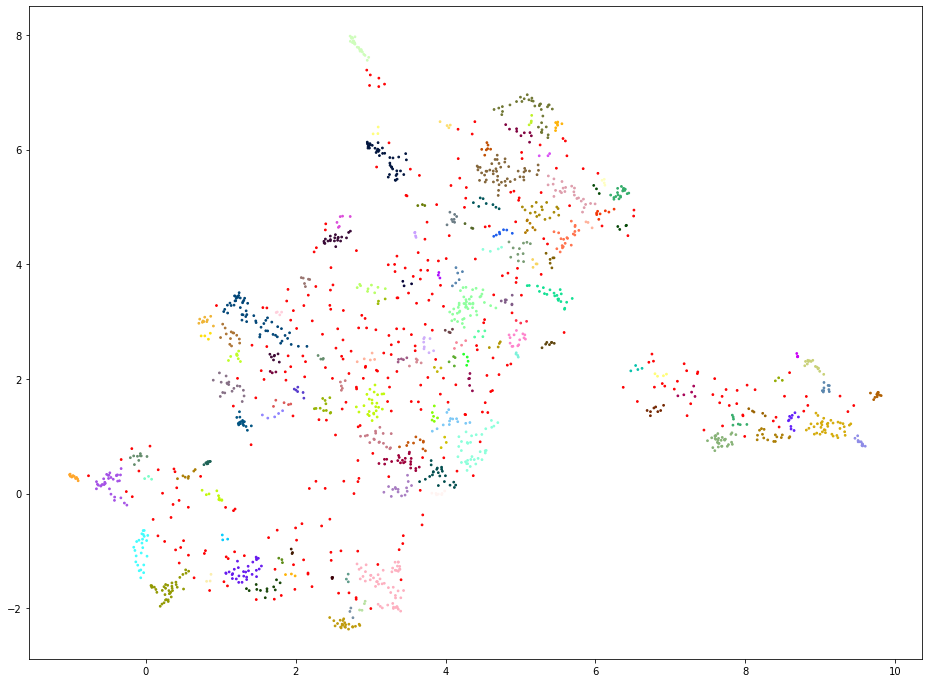

In [52]:
clusters = cluster_texts_and_draw(umaped_vct, umaped_vct, 0.12)

In [53]:
show_texts_in_clusters(news.Header, clusters, 10, 3)

          __  0  __
Раскрыто происхождение новейшей украинской крылатой ракеты
Американский «Морской охотник» попал на видео
США оценили возможность России первой использовать ядерное оружие

          __  1  __
Социологи подсчитали планирующих проголосовать на выборах-2018
Назван предмет гордости россиян в науке
Иностранный бизнес поверил в Россию

          __  2  __
Названа причина исчезновения рыболовецкого судна «Восток»
Полный самолет сантехников вернулся в аэропорт из-за сломанного туалета
Путешественников из Нового Уренгоя подвез атомный ледокол

          __  3  __
Учитель угодил под суд за оральный секс со спящим школьником
Самарский подросток объяснил желание напасть на школу
Обвиняемый предложил судье полюбоваться на его пенис

          __  4  __
Украинский депутат призвал к убийствам «непатриотов»
США возмутил взгляд Польши на холокост
Москву заинтересовал запрет Польши на «бандеровскую идеологию»

          __  5  __
С космодрома Восточный запустили третью ракету
США рас

В коде выше мы исходили из того, что на плоскости тексты расположились лучше, чем в исходном 300-мерном пространстве. Попробуем провести кластеризацию в исходном пространстве и сравним получившиеся рисунки.

27


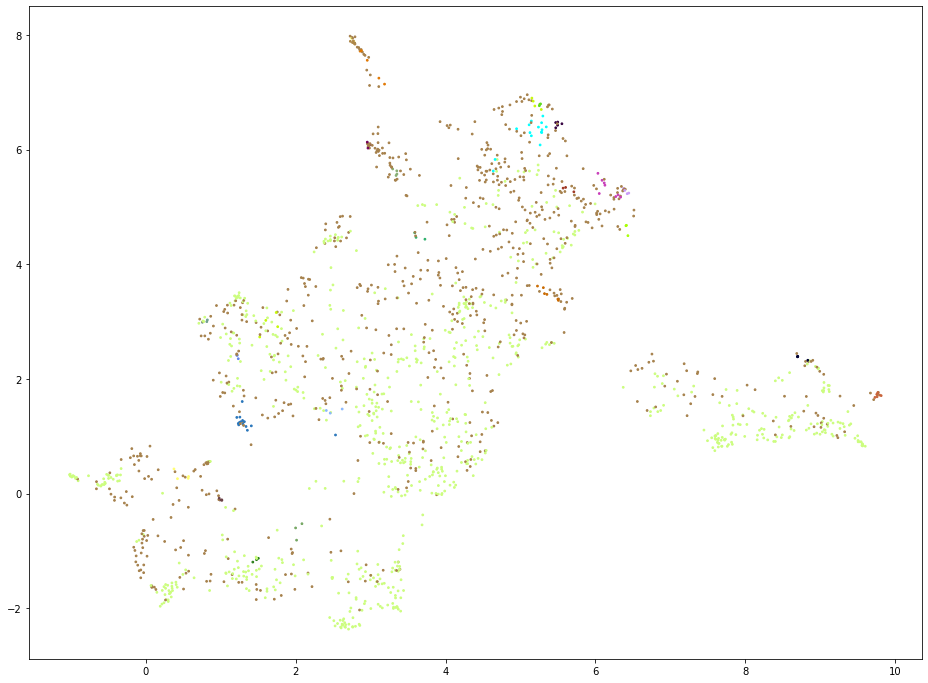

In [55]:
clusters = cluster_texts_and_draw(w2v_vectors, umaped_vct, 0.17)

In [56]:
show_texts_in_clusters(news.Header, clusters, 10, 3)

          __  0  __
Раскрыто происхождение новейшей украинской крылатой ракеты
Звезду сериала «Детективы» задержали за работу детектива
С космодрома Восточный запустили третью ракету

          __  1  __
Социологи подсчитали планирующих проголосовать на выборах-2018
На выборы президента России пойдут почти 80 процентов избирателей
Грудинин уступил в популярности КПРФ

          __  2  __
Найдены препараты против старения
Опровергнут главный миф об омоложении человека
Найдено предотвращающее старение вещество

          __  3  __
Неймар заставит «Барселону» расплатиться
Роналду вошел в положение «Реала» и заслужил повышение зарплаты
Щуплость и конкуренция с Гатаговым избавили Неймара от карьеры в России

          __  4  __
Американская супермодель обвинила соучредителя Guess в домогательствах
Жертва насильника придумала шорты для защиты от насильников
Номинант на «Оскар» заставил поклонников люкса предаться размышлениям

          __  5  __
Названы самые погрязшие в сугробах районы сто

### Группировка слов, похожих по смыслу

При объединении всех векторов текста происходит размытие его смысла за счет того, что некоторые понятия хоть и являются близкими, но имеют различия. Вместо того, чтобы брать само слово, давайте объединим все слова одной группы и будем брать их центроид. Заодно посмотрим какие слова попадают в одну группу.

In [57]:
def get_most_frequent_words_from_model(model, texts, threshold=20):
    """ Функция выделяет слова, которые встречаются в текстах texts не реже, чем threshold раз,
        и при этом имеются в предобученной модели model. Также возвращает вектора этих слов.
    """
    vctr = CountVectorizer(lowercase=False)
    cntr = vctr.fit_transform(texts)
    
    res_words = []
    res_vects = []
    summed = cntr.sum(axis=0)
    klist = list(vctr.vocabulary_.keys())
    for i in range(summed.shape[1]):
        if summed[0, i] > threshold:
            try:
                res_vects.append(model[klist[i]])
                res_words.append(klist[i])
            except:
#                 print(klist[i])
                pass
    
    return res_words, res_vects

In [58]:
sci_words, sci_vects = get_most_frequent_words_from_model(model_w2v, sci_texts['NText'], 10)

In [59]:
len(sci_words)

7880

In [64]:
%%time
# Кластеризуем, в среднем по два слова на кластер.
sci_clust_no = int(len(sci_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 11min 12s, sys: 12min 5s, total: 23min 18s
Wall time: 3min 50s


In [65]:
# Немного преобразуем структуру данных, чтобы потом было удобнее работать.
sci_words_sorted = sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])
# sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

In [66]:
# Какие слова попадают в один кластер?
clust_no = 22
print([word[1] for word in sci_words_sorted if word[0]==clust_no])

['замачиваться_VERB', 'протирать_VERB', 'смачивать_VERB', 'ватный_ADJ', 'салфетка_NOUN', 'растирать_VERB']


In [67]:
# Посчитаем координаты центроидов.
cur_clust = sci_words_sorted[0][0]
cur_coord = np.array(model_w2v[sci_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(sci_words_sorted[1:]):
    if cur_clust == sci_words_sorted[i+1][0]:
        cur_coord += model_w2v[sci_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = sci_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[sci_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)


In [68]:
# Эта функция берет центры кластеров вместо слов.
def text_to_vec_centr(text, model_w2v, clust_coord, sci_words_d):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in sci_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[sci_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


In [69]:
# Строим вектора для слов.
sci_vect2 = []
for text in tqdm(sci_texts.Text):
    sci_vect2.append(text_to_vec_centr(text, model_w2v, clust_coord, sci_words_d))

  0%|          | 0/5000 [00:00<?, ?it/s]

65


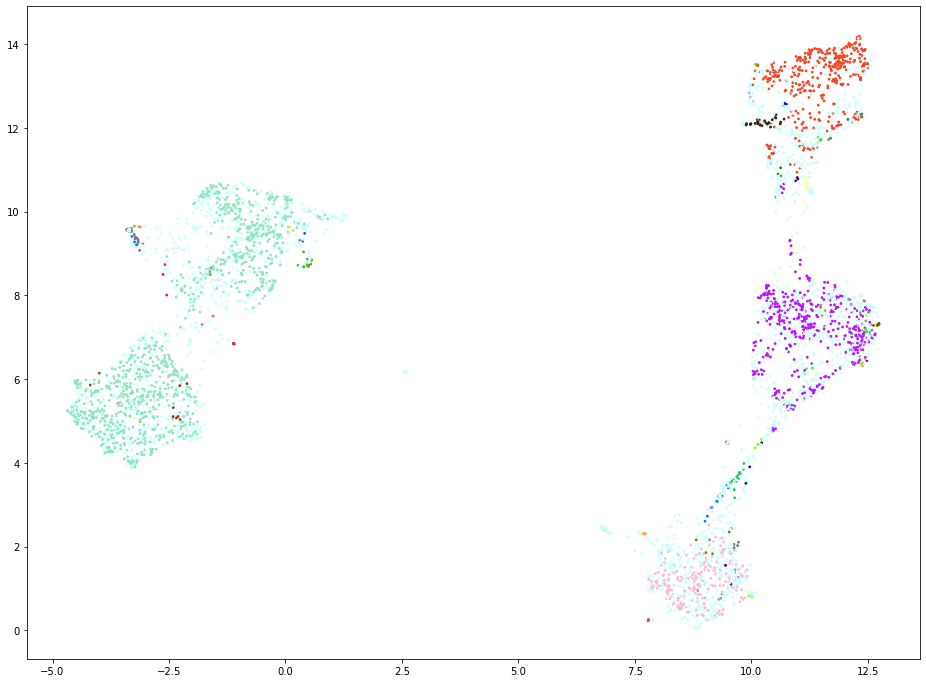

In [70]:
# Посмотрим как распределятся документы при таком подходе.
umaped_vct2 = UMAP().fit_transform(sci_vect2)
clusters = cluster_texts_and_draw(sci_vect2, umaped_vct2, 0.09)

In [71]:
show_texts_in_clusters(sci_texts.Text, clusters, 10, 3)

          __  0  __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.в. данилова                сыр, благодаря ег
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя

          __  1  __
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                формирование вертикально-интегрированных образован
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                форми

Хорошо, и насколько мы выиграли от применения вот таких векторов? Снова возьмем наши научные тексты, поделим на обучающую и тестовую выборки и посмотрим с каким качеством они классифицируются.

In [73]:
classify_texts(sci_vect2, classes)

accuracy = 0.971%
[[201   0   5   2   1]
 [  1 182   7   0   0]
 [  3   0 201   2   0]
 [  0   0   0 192   1]
 [  0   0   0   7 195]]


-----

## FastText

Одним из недостатков модели Word2Vec является тот факт, что для слов, отсутствующих в модели, вектор возвращаться не будет. Для того, чтобы исправить этот недостаток, была разработана модель FastText, которая строит векторы не для слов, а для их частей. Тогда вектор слова может быть составлен как среднее по векторам его частей (но так не часто делают), а среднее для текста - как среднее по всем частям слов (а это мы уже делали).

**Внимание!!!** Я специально закомментировал загрузку модели в память, так как подходы Bert и Elmo используют точно такой же принцип. Так что как слова распадаются на части мы с вами посмотрим на модели Bert. А так - ниже находится вполне рабочий код.


In [110]:
from gensim.models.fasttext import FastText

In [51]:
# Загрузка модели в память

#model_ft = KeyedVectors.load_fasttext_format('data/araneum_none_fasttextskipgram_300_5_2018.tgz', binary=True)

#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')


In [112]:
# В выбранной модели части речине используются, так что надо переразметить тексты без них.
all_sentences = []
for text in tqdm(news.News):
    all_sentences.extend(normalizePymorphy(text, False))

  0%|          | 0/1708 [00:00<?, ?it/s]

In [114]:
%%time
# Модель обучается точно так же, только надо создать другой объект.

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели


model_ft = FastText(all_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 19.9 s, sys: 1.75 s, total: 21.7 s
Wall time: 10.4 s


In [116]:
# Кстати, модели можно сохранять.
model_ft.save("data/fast_text_news.bin")

In [117]:
model_ft = FastText.load("data/fast_text_news.bin")
#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')
# Мне не хватило 16 Гб оперативной памяти, чтобы загрузить эту модель.
#model_ft = FastText.load_fasttext_format("data/cc.ru.300.bin.gz")

In [118]:
# Точно так же работает векторная арифметика.
model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']- model_ft.wv['королева_']


array([ 0.02371459, -0.01048715, -0.0270489 ,  0.01300185,  0.01777178,
        0.01834881,  0.02035419,  0.01355439, -0.00031965, -0.03762834,
        0.0570448 , -0.01739284, -0.02076318,  0.00501096, -0.00482356,
        0.01507597, -0.00537466, -0.00023278,  0.03428209,  0.00416109,
        0.04182412, -0.02270348,  0.01428392, -0.00099169,  0.00965798,
        0.00619522, -0.00069699,  0.00164337,  0.02515025, -0.06242841,
       -0.01504815,  0.00833768, -0.00851485,  0.00746039, -0.01334605,
        0.02753113, -0.00349931,  0.00714848, -0.01741816, -0.00459334,
       -0.02480294,  0.00288832, -0.00753802,  0.00785273,  0.04151852,
       -0.00558464, -0.00486442,  0.01806958, -0.01179049, -0.01219531,
        0.01841792, -0.00817893, -0.01381779,  0.01052645, -0.02821652,
       -0.04744896,  0.00861019,  0.02883787,  0.00692776, -0.01645585,
       -0.02286763,  0.00423228,  0.00598198,  0.003709  ,  0.03134623,
        0.03572293,  0.05438006,  0.01213864,  0.01051805, -0.01

In [120]:
#model_ft.wv.most_similar(positive=[u'пожар'])
#model_ft.wv.most_similar(positive=[u'пожар'], negative=[u'пламя'])
#model_ft.wv.most_similar(positive=[u'топливо_'], negative=[u'нефть_'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_'])
#model_ft.most_similar(positive=[u'король', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(positive=[u'президент', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(negative=[u'король', u'мужчина'], positive=[u'женщина'])
#model_ft.most_similar(positive=[u'женщина_', u'король_'])
#model_ft.most_similar(positive=['германия_', 'москва_' ], negative=['берлин_'])
print(model_ft.wv.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_']), "\n\n",
model_ft.wv.most_similar([model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']]))

[('ка', 10.026437759399414), ('тема', 7.957744121551514), ('ан', 7.874449729919434), ('по', 7.083878517150879), ('материал', 6.535669803619385), ('олимпийский', 6.499141693115234), ('ник', 6.439122200012207), ('мать', 6.230875015258789), ('до', 6.216174125671387), ('кой', 6.0047149658203125)] 

 [('ка', 10.045478820800781), ('ан', 7.890819549560547), ('тема', 7.824236869812012), ('по', 7.004166603088379), ('олимпийский', 6.5339555740356445), ('ник', 6.461309432983398), ('материал', 6.444485664367676), ('до', 6.194974899291992), ('мать', 6.185122489929199), ('кой', 6.016816139221191)]


## BERT

Bert исправляет сразу несколько недостатков, которые имеются у Word2Vec. Во-первых, как и FastText, он разбивает слова на части и приписывает вектора именно им. Помимо этого, вектор приписывается слову в контексте. Если слово обладает несколькими значениями, контекст может помочь определить конкретное значение употребления этого слова. По данному признаку все модели делятся на статические и контекстуализированные. Статические, такие как Word2Vec и FastText, возвращают вектор по слову. Контекстуализированные, такие как Bert и Elmo, получают на вход предложение, используют его как контекст и возвращают векторы для всех слов (частей слов) предложения.

Word2Vec обучает нейронную сеть, получает с ее помощью векторы для всех слов, а дальше работает как словарь. В основе Bert лежит более умная нейронная сеть, и Bert применяет ее для того, чтобы вывести вектор для всех слов в переданном тексте. То есть Word2Vec хранит словарь, Bert хранит веса нейросети.

In [60]:
from transformers import AutoTokenizer, AutoModel
import torch

from scipy.spatial.distance import cosine
import numpy as np


In [61]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
# model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")


In [62]:
marked_text = "[CLS] папа мыл раму [SEP]"

# marked_text = "[CLS] " + words_to_embed + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])


In [77]:
tokens_tensor

tensor([[   101,  24820,   8235,    864, 102556,    102]])

In [64]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def encode_sentence(sent, tokenizer, model):

    sentenses = [sent]

    embeddings_list = []

    for s in sentenses:
        encoded_input = tokenizer(s, padding=True, truncation=True, max_length=64, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**encoded_input)
        embedding = model_output.pooler_output
        embeddings_list.append((embedding)[0].numpy())

    embeddings = np.asarray(embeddings_list)
    print(encoded_input)
    print(tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]))
#     print(model_output.last_hidden_state[0][0])
    print(model_output[0][0])
    return model_output[0][0]

"Папа" в разных контекстах не похож сам на себя.

In [70]:
s1 = encode_sentence("папа моет раму", tokenizer, model)
s2 = encode_sentence("папа строит дом", tokenizer, model)
s3 = encode_sentence("папа чистит раму", tokenizer, model)
s4 = encode_sentence("папа мыл раму", tokenizer, model)
s5 = encode_sentence("папа пьет виски", tokenizer, model)
s6 = encode_sentence("добрый папа пьет виски", tokenizer, model)
s7 = encode_sentence("коптроваркующийся папа моет раму", tokenizer, model)
s8 = encode_sentence("папа моет раму и папа пьет виски", tokenizer, model)


{'input_ids': tensor([[   101,  24820,  63446,    868, 102556,    102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
['[CLS]', 'папа', 'мое', '##т', 'раму', '[SEP]']
tensor([[-0.3193, -1.6489, -0.3192,  ..., -0.0267, -0.9146,  0.5733],
        [-0.4512, -1.6331, -0.3669,  ...,  0.0099, -0.8661,  0.6919],
        [-0.5246, -1.5206, -0.1529,  ..., -0.1230, -0.9982,  0.3878],
        [-0.3371, -1.4831, -0.0857,  ..., -0.1765, -0.8713,  0.4650],
        [-0.5339, -1.6255, -0.2936,  ...,  0.0850, -0.8995,  0.4632],
        [-0.3695, -1.6970, -0.2170,  ..., -0.0244, -0.9270,  0.6046]])
{'input_ids': tensor([[  101, 24820, 50967,  4439,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
['[CLS]', 'папа', 'строит', 'дом', '[SEP]']
tensor([[-0.0379, -2.0546,  0.0429,  ..., -0.0187, -0.7367,  0.5848],
        [-0.2073, -1.9770, -0.0249,  ..., -0.0037, -0.6234,  0.7693],
        [-0.0272, -1.9785

In [66]:
s1

tensor([[-0.3193, -1.6489, -0.3192,  ..., -0.0267, -0.9146,  0.5733],
        [-0.4512, -1.6331, -0.3669,  ...,  0.0099, -0.8661,  0.6919],
        [-0.5246, -1.5206, -0.1529,  ..., -0.1230, -0.9982,  0.3878],
        [-0.3371, -1.4831, -0.0857,  ..., -0.1765, -0.8713,  0.4650],
        [-0.5339, -1.6255, -0.2936,  ...,  0.0850, -0.8995,  0.4632],
        [-0.3695, -1.6970, -0.2170,  ..., -0.0244, -0.9270,  0.6046]])

In [74]:
cosine(s1[1], s6[6])

0.5044878721237183

Одна из ошибок, которые можно совершить, работая с Bert - это отдавать текст по одному предложению. Скорость работы при этом критично падает. Лучше отдавать текст целиком (если это не "Война и мир"), предварительно разбив его на предложения.

## Самостоятельная работа

Возьмите Bert, возьмите новости, векторизуйте тексты как мы это делали выше (среднее по всем векторам), проведите классификацию научных текстов, посчитайте долю правильных ответов системы и матрицу ошибок.

### Что осталось за кадром?

- ELMO
- EmbeddingLayer